17/06/2021

**Tiago Pereira Dall'Oca - 206341**

---

In [1]:
from scipy import misc
from scipy import ndimage
from scipy.fft import ifftn
from scipy.spatial.distance import pdist
from scipy.ndimage import rotate
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from math import sqrt
import os
from skimage.feature import local_binary_pattern
from scipy.spatial.distance import euclidean
from dictances import bhattacharyya, chi_square
from skimage.feature.texture import greycomatrix, greycoprops

import warnings
warnings.filterwarnings('ignore')

# Introdução

Este trabalho foi desenvolvido utilizando a plataforma de prototipação e experimentção [Jupyter](https://jupyter.org). A intenção foi permitir que o trabalho fosse desenvolvido de forma gradual, já que as celulas são executadas uma por vez e os resultdados são obtidos de forma incremental.

Estou enviando, junto do pdf do notebook,o notebook original. A intenção é que a imagem de input pode ser alterada com bastante facilidade e basta rodar as células em sequência para obter os resultados discutidos.

## Imagens - Transformações de Cores

In [2]:
folder_name = 'images/'
img_file_names = [folder_name + x for x in os.listdir(folder_name)]
img_file_names.sort()
img_file_names

['images/textura1.png',
 'images/textura2.png',
 'images/textura3.png',
 'images/textura4.png']

In [3]:
imgs = [cv2.imread(x, cv2.IMREAD_GRAYSCALE) for x in img_file_names]

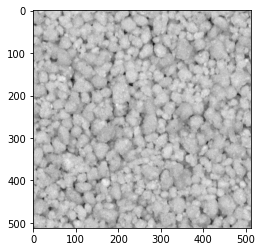

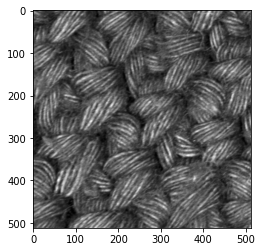

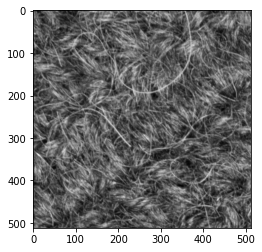

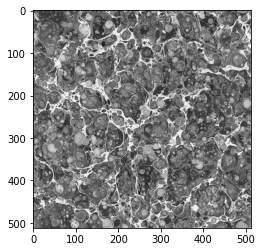

In [4]:
for img in imgs:
    plt.figure()
    plt.imshow(img, 'gray')

# Padrões Binários Locais

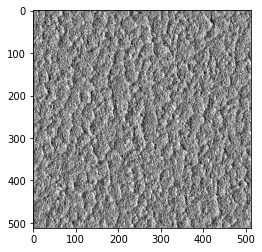

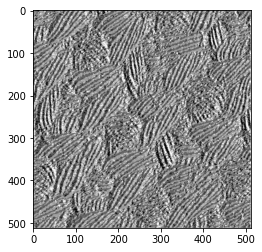

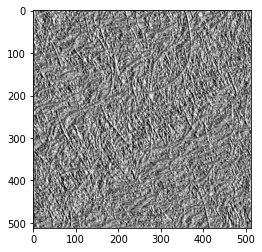

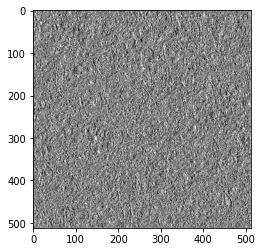

In [5]:
p , r = 8, 1
lbps1 = [local_binary_pattern(x, p, r,).astype('int8') + 128 for x in imgs]
for lbp in lbps1:
    plt.figure()
    plt.imshow(lbp, 'gray')

# Comparações entre imagens e texturas

## Novas imagens

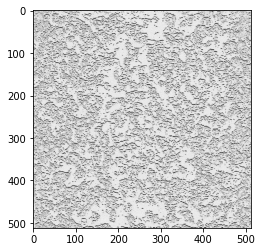

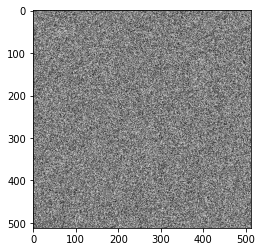

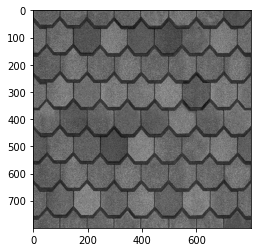

In [6]:
folder_name = 'custom_images/'
img_file_names = [folder_name + x for x in os.listdir(folder_name)]
img_file_names.sort()
img_file_names
imgs = [cv2.imread(x, cv2.IMREAD_GRAYSCALE) for x in img_file_names]
for img in imgs:
    plt.figure()
    plt.imshow(img, 'gray')

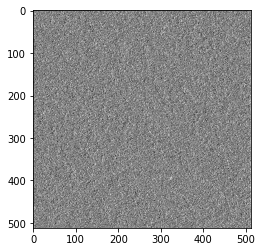

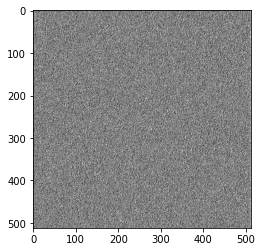

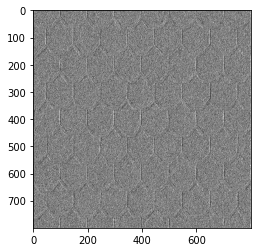

In [7]:
p , r = 8, 1
lbps1 = [local_binary_pattern(x, p, r,).astype('int8') + 128 for x in imgs]
for lbp in lbps1:
    plt.figure()
    plt.imshow(lbp, 'gray')

In [8]:
n_bins = 32
hists_bins = [np.histogram(x, bins=n_bins, density=True) for x in lbps1]

Ao que já podemos observar, os histogramas das texturas 1 e 2 são mais parecidos

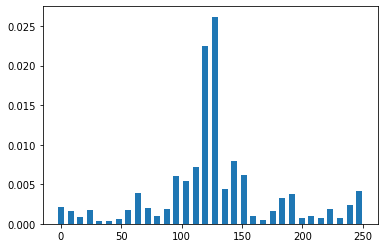

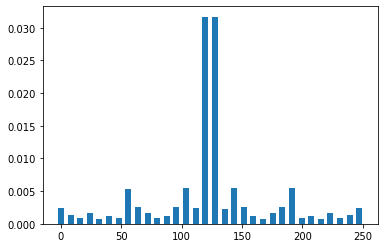

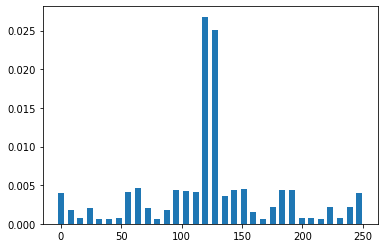

In [9]:
for hb in hists_bins:
    plt.figure()
    (h, b) = hb
    plt.bar(b[:-1], h, width=5)

Comparações entre as texturas 1 e 2

In [10]:
textura1Dict = dict(zip(hists_bins[0][1], hists_bins[0][0]))
textura2Dict = dict(zip(hists_bins[1][1], hists_bins[1][0]))
print('distância euclidiana:', euclidean(hists_bins[0][0], hists_bins[1][0]))
print('distância de bhattacharyya:', bhattacharyya(textura1Dict, textura2Dict))
print('chi-quadrado (correlação):', chi_square(textura1Dict, textura2Dict))

distância euclidiana: 0.01398057642903569
distância de bhattacharyya: 2.102538089151091
chi-quadrado (correlação): 0.01282980764867608


Comparações entre as texturas 1 e 3

In [11]:
textura3Dict = dict(zip(hists_bins[2][1], hists_bins[2][0]))
print('distância euclidiana:', euclidean(hists_bins[2][0], hists_bins[0][0]))
print('distância de bhattacharyya:', bhattacharyya(textura3Dict, textura1Dict))
print('chi-quadrado (correlação):', chi_square(textura3Dict, textura1Dict))

distância euclidiana: 0.007821083528106286
distância de bhattacharyya: 2.0863949874294705
chi-quadrado (correlação): 0.005320562686953332


Ao que as comparações mostram, a textura das imagens 1 e 2 são mais parecidas entre sí do que se qualquer uma delas com a textura 3 (lembrando que me refiro aqui às imagens 'novas', da pasta 'custom_images').

Isso já era de se esperar fazendo uma comparação preliminar dos histogramas.

Aqui, comparamos o contraste entre as texturas usando matrizes de concorrência:

In [12]:
gcms = [greycomatrix(x, distances=[1,2], angles=[0, np.pi/2], symmetric=True, normed=True) for x in imgs]
for g in gcms:
    print('contrastes:', ' '.join(map(str, greycoprops(g, 'contrast'))))

contrastes: [2157.23571276 4762.6848436 ] [4404.9447572  7350.59110754]
contrastes: [10888.30432822 10894.08352954] [10955.47723652 10908.9782935 ]
contrastes: [435.78359043 430.9862985 ] [663.13093358 652.73632049]
